In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from river import drift
from itertools import product
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore')

In [309]:
''' Leitura do arquivo com as funções necessárias pro pré-processamento e processamento do dados '''
# json_processed_data(folder_path), gpx_processed_data(data_folder_path) e fit_processed_data(data_folder_path)
%run C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/scripts/final/functions.ipynb

In [4]:
''' Contador de arquivos dentro da pasta '''

# Caminho da pasta com as pastas contendo as atividades de cada atleta
data_folders_path = 'C:/Users/USER/Desktop/EstudosDados/Projetos/Corrida/physical_inactivity_prediction/athletes_activities'

folders_count = 0

for file in os.listdir(data_folders_path):
    folders_count += 1

print(folders_count)

7


In [5]:
# Criação do Dataframe que terá os valores de cada atleta por id
df_athletes_activities = pd.DataFrame()

# Número do primeiro id (Se começar com 0, mudar para n = 0)
n = 1

# Iteração para criar o Dataframe com os valores de cada atleta por id
for athlete_id in range(n, folders_count + n):

    # Nome do arquivo com os dados do atleta
    athlete_foldername = f'athlete{athlete_id}'

    # Junção da pasta com as pastas contendo as atividades de cada atleta e o nome da pasta com os dados do atleta por id
    data_folder_path = os.path.join(data_folders_path, athlete_foldername)

    # Pegando a primeira atividade da pasta
    first_file = os.listdir(data_folder_path)[0]
    
    if first_file.endswith('.gpx'):
        # Criação do Dataframe a partir da função de processamento de dados gpx
        df = gpx_processed_data(data_folder_path)

    elif first_file.endswith('.json'):
        # Criação do Dataframe a partir da função de processamento de dados gpx
        df = json_processed_data(data_folder_path)

    elif first_file.endswith('.fit'):
        # Criação do Dataframe a partir da função de processamento de dados gpx
        df = fit_processed_data(data_folder_path)
    
    df_athlete_activity = activities_time_frequency(df)

    # Adição de uma coluna athlete_id para identificar os dados de cada atleta
    df_athlete_activity.insert(0, 'athlete_id', athlete_id)

    # Concatenação dos valores de cada atleta por id a um Dataframe
    df_athletes_activities = pd.concat([df_athletes_activities, df_athlete_activity])

df_athletes_activities.reset_index(drop=True, inplace=True)

In [6]:
df_athletes_activities

,athlete_id,activity_date,activity_type,total_distance (km),total_time (min),pace (min/km),velocity (km/h),days_between_activities
0,1,2020-07-09,Activity,6.03,39.0,6.47,9.27,0
1,1,2020-07-10,Activity,25.35,140.0,5.52,10.87,0
2,1,2020-07-11,No Activity,NaN,NaN,NaN,NaN,1
3,1,2020-07-12,No Activity,NaN,NaN,NaN,NaN,2
4,1,2020-07-13,Activity,7.57,55.0,7.27,8.25,0
...,...,...,...,...,...,...,...,...
4621,7,2024-06-25,No Activity,NaN,NaN,NaN,NaN,3
4622,7,2024-06-26,No Activity,NaN,NaN,NaN,NaN,4
4623,7,2024-06-27,Activity,4.08,22.0,5.40,11.12,0
4624,7,2024-06-28,No Activity,NaN,NaN,NaN,NaN,1


In [7]:
df_athletes_activities.groupby('athlete_id')['activity_type'].value_counts()

athlete_id  activity_type
1           No Activity       596
            Activity          113
2           No Activity      1101
            Activity           62
3           No Activity       186
            Activity           95
4           No Activity      1051
            Activity          149
5           No Activity       632
            Activity          328
6           No Activity       134
            Activity           78
7           No Activity        58
            Activity           43
Name: count, dtype: int64

Text(0, 0.5, 'Days')

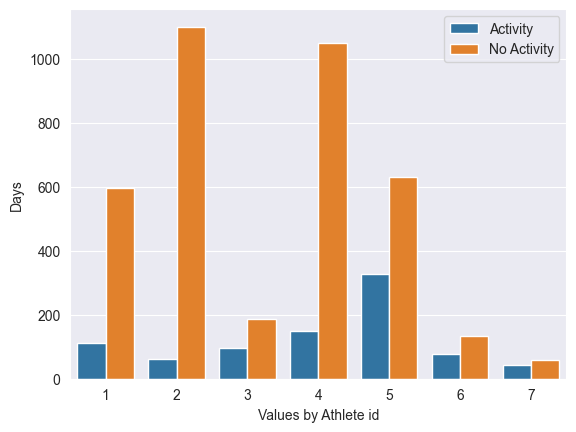

In [8]:
sns.set_style('darkgrid')
g = sns.countplot(df_athletes_activities, hue="activity_type", x='athlete_id')
g.legend().set_title(None)
plt.xlabel('Values by Athlete id')
plt.ylabel('Days')

In [9]:
df_athletes_activities_new = df_athletes_activities[['athlete_id', 'activity_date', 'activity_type','days_between_activities']]

df_athletes_activities_new['activity_type'] = (df_athletes_activities_new['activity_type'] == 'Activity') * 1
df_athletes_activities_new

,athlete_id,activity_date,activity_type,days_between_activities
0,1,2020-07-09,1,0
1,1,2020-07-10,1,0
2,1,2020-07-11,0,1
3,1,2020-07-12,0,2
4,1,2020-07-13,1,0
...,...,...,...,...
4621,7,2024-06-25,0,3
4622,7,2024-06-26,0,4
4623,7,2024-06-27,1,0
4624,7,2024-06-28,0,1


In [73]:
# Quantidade de atividades num período específico de dias
activity_days = 7 # 7 = 1 semana, 14 = 2 semanas

# Somando o número de atividades dentro desse período de dias em uma janela deslizante, por atleta
df_athletes_activities_new['activities_moving_sum'] = [values for values in df_athletes_activities_new.groupby('athlete_id')['activity_type'].rolling(activity_days).sum()]

df_athletes_activities_new

,athlete_id,activity_date,activity_type,days_between_activities,activities_moving_sum
0,1,2020-07-09,1,0,NaN
1,1,2020-07-10,1,0,NaN
2,1,2020-07-11,0,1,NaN
3,1,2020-07-12,0,2,NaN
4,1,2020-07-13,1,0,NaN
...,...,...,...,...,...
4621,7,2024-06-25,0,3,5.0
4622,7,2024-06-26,0,4,4.0
4623,7,2024-06-27,1,0,5.0
4624,7,2024-06-28,0,1,4.0


In [74]:
# Dicionário para adicionar os exemplos
examples_dict = []

# Lista com o id de cada atleta
athlete_ids = df_athletes_activities_new['athlete_id'].unique()

# Quantidade de atividades para estar dentro do período específico
activities_qtd = 3 # 2 dias ou 3 dias

# Iteração a partir do id do atleta
for athlete_id in athlete_ids:
    # Inicializando com periodo ativo como Falso
    active_period = False
    # Atribuindo a uma variável o dataframe filtrado por id do atleta
    df_athlete = df_athletes_activities_new.loc[df_athletes_activities_new['athlete_id'] == athlete_id]

    # Iteração pelas linhas com a série de cada atleta por id
    for index, row in df_athlete.iterrows():
        # Condição para caso a soma de atividades no periodo específico seja >= activities_qtd, se inicializa o periodo ativo
        if (row['activities_moving_sum'] >= activities_qtd) & (active_period == False):
            active_period = True
            active_period_dict = {'athlete_id': athlete_id, 'start': row['activity_date']}

        # Condição para finalizar o período ativo caso a soma de atividade no período ativo seja igual 0
        elif (row['activities_moving_sum'] == 0) & (active_period == True):
            active_period_dict['end'] = row['activity_date']
            active_period_dict['data'] = df_athlete[(df_athlete['activity_date'] >= active_period_dict['start']) & (df_athlete['activity_date'] <= active_period_dict['end'])].reset_index(drop=True)
            active_period = False    
            examples_dict.append(active_period_dict)

In [268]:
# Dataframe com os dados dos atletas que tiveram inicio e fim de períodos ativos para compor exemplos
df_examples = pd.DataFrame(examples_dict)
df_examples

,athlete_id,start,end,data
0,1,2020-07-22,2020-10-08,athlete_id activity_date activity_type d...
1,1,2020-10-28,2021-05-19,athlete_id activity_date activity_type ...
2,3,2023-10-21,2023-11-25,athlete_id activity_date activity_type d...
3,3,2023-12-17,2024-05-24,athlete_id activity_date activity_type ...
4,5,2021-11-21,2022-01-17,athlete_id activity_date activity_type d...
5,5,2022-02-06,2023-02-24,athlete_id activity_date activity_type ...
6,5,2023-09-10,2024-01-13,athlete_id activity_date activity_type ...
7,6,2023-08-05,2023-10-14,athlete_id activity_date activity_type d...


In [284]:
df_examples_train, df_examples_test = train_test_split(df_examples, test_size=0.2, random_state=123)
df_examples_train.reset_index(drop=True, inplace=True)
df_examples_test.reset_index(drop=True, inplace=True)

In [285]:
df_examples_train

,athlete_id,start,end,data
0,3,2023-12-17,2024-05-24,athlete_id activity_date activity_type ...
1,6,2023-08-05,2023-10-14,athlete_id activity_date activity_type d...
2,5,2021-11-21,2022-01-17,athlete_id activity_date activity_type d...
3,3,2023-10-21,2023-11-25,athlete_id activity_date activity_type d...
4,5,2022-02-06,2023-02-24,athlete_id activity_date activity_type ...
5,5,2023-09-10,2024-01-13,athlete_id activity_date activity_type ...


In [286]:
df_examples_test

,athlete_id,start,end,data
0,1,2020-07-22,2020-10-08,athlete_id activity_date activity_type d...
1,1,2020-10-28,2021-05-19,athlete_id activity_date activity_type ...


In [456]:
''' ADWIN '''
adwin_params_dict = {'delta': [0.0001, 0.005, 0.001, 0.05, 0.01],
                     'min_window_length': [5, 10, 20, 30, 40],
                     'clock': [1, 2, 3, 4, 5],
                     'max_buckets': [5, 10, 15, 20, 25],
                     'grace_period': [5, 10, 15, 20, 25]}

''' KSWIN '''
kswin_params_dict = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1],
                     'window_size':[100, 200, 300, 400, 500],
                     'stat_size': [5, 10, 15, 20, 25],
                     'seed': [321]}

''' Page Hinkley '''
ph_params_dict = {'delta': [0.0001, 0.005, 0.001, 0.05, 0.01],
                  'min_instances': [30, 50, 100, 200, 300],
                  'threshold': [1.0, 2.0, 3.0, 4.0, 5.0],
                  'alpha': [0.5, 1.0, 1.5, 2.0, 2.5]}


products = [['ADWIN', [dict(zip(('delta', 'min_window_length', 'clock', 'max_buckets', 'grace_period'), (i,j,k,w,z))) for i,j,k,w,z in product(adwin_params_dict['delta'], adwin_params_dict['min_window_length'], adwin_params_dict['clock'], adwin_params_dict['max_buckets'], adwin_params_dict['grace_period'])]],
            ['KSWIN', [dict(zip(('alpha', 'window_size', 'stat_size', 'seed'), (i,j,k,w))) for i,j,k,w in product(kswin_params_dict['alpha'], kswin_params_dict['window_size'], kswin_params_dict['stat_size'], kswin_params_dict['seed'])]],
            ['PageHinkley', [dict(zip(('delta', 'min_instances', 'threshold', 'alpha'), (i,j,k,w))) for i,j,k,w in product(ph_params_dict['delta'], ph_params_dict['min_instances'], ph_params_dict['threshold'], ph_params_dict['alpha'])]]]

In [296]:
# Valor para criar o range de drifts como TP
x = 3

# Contador para cada paramêtro utilizado nos métodos para cada exemplo
param_combination_id = 0

# Performance resultada com a função de detecção de drift
train_results = []

# Iteração pela lista products contendo na primeira posição o nome do método e na segunda as combinações de parâmetros
for drift_method, params in products:
    # Iteração pela combinação de parâmetros para trabalhar com elas separadamente                   
    for param in params:
        # Contador para identicar o exemplo processado
        example_id = 0
        # Iteração por cada df contendo um exemplo
        for df_example_train in df_examples_train['data']:
            # Condição para detectar drift com as combinações de parâmetros caso o método seja ADWIN
            if drift_method == 'ADWIN':
                train_results.append(drift_detection(df_example_train, drift.ADWIN(**param), param, drift_method, x, param_combination_id, example_id))

            # Condição para detectar drift com as combinações de parâmetros caso o método seja KSWIN
            elif drift_method == 'KSWIN':
                train_results.append(drift_detection(df_example_train, drift.KSWIN(**param), param, drift_method, x, param_combination_id, example_id))
                
            # Condição para detectar drift com as combinações de parâmetros caso o método seja Page Hinkley
            elif drift_method == 'PageHinkley':
                train_results.append(drift_detection(df_example_train, drift.PageHinkley(**param), param, drift_method, x, param_combination_id, example_id))
            
            example_id += 1

        param_combination_id += 1

In [345]:
df_results_train = pd.DataFrame(train_results)
df_results_train

,Parameter Combination id,Example id,Example,Drift Parameters,Drift Method
0,0,0,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN
1,0,1,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN
2,0,2,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN
3,0,3,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN
4,0,4,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN
...,...,...,...,...,...
331,55,1,athlete_id activity_date activity_type d...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley
332,55,2,athlete_id activity_date activity_type d...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley
333,55,3,athlete_id activity_date activity_type d...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley
334,55,4,athlete_id activity_date activity_type ...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley


In [383]:
df_results_train_evaluate = df_results_train.copy()

for index, row in df_results_train_evaluate.iterrows(): 
    
    df_results_train_evaluate.loc[index, 'TP'] = evaluate(df_results_train_evaluate.loc[index, 'Example'])[0]
    df_results_train_evaluate.loc[index, 'TN'] = evaluate(df_results_train_evaluate.loc[index, 'Example'])[1]
    df_results_train_evaluate.loc[index, 'FP'] = evaluate(df_results_train_evaluate.loc[index, 'Example'])[2]
    df_results_train_evaluate.loc[index, 'FN'] = evaluate(df_results_train_evaluate.loc[index, 'Example'])[3]

df_results_train_evaluate

,Parameter Combination id,Example id,Example,Drift Parameters,Drift Method,TP,TN,FP,FN
0,0,0,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN,0.0,153.0,0.0,1.0
1,0,1,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN,0.0,64.0,0.0,1.0
2,0,2,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN,0.0,51.0,0.0,1.0
3,0,3,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN,0.0,29.0,0.0,1.0
4,0,4,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_window_length': 5, 'clo...",ADWIN,0.0,377.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
331,55,1,athlete_id activity_date activity_type d...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley,0.0,63.0,1.0,1.0
332,55,2,athlete_id activity_date activity_type d...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley,0.0,50.0,1.0,1.0
333,55,3,athlete_id activity_date activity_type d...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley,0.0,29.0,0.0,1.0
334,55,4,athlete_id activity_date activity_type ...,"{'delta': 0.005, 'min_instances': 50, 'thresho...",PageHinkley,0.0,370.0,7.0,1.0


In [348]:
df_results_train_grouped = df_results_train_evaluate.groupby('Parameter Combination id').agg({'TP': 'sum', 'TN': 'sum', 'FP': 'sum', 'FN': 'sum'})

for index, row in df_results_train_grouped.iterrows():
    
    df_results_train_grouped.loc[index, 'Precision'] = metrics(row['TP'], row['FP'], row['TN'], row['FN'])[0]
    df_results_train_grouped.loc[index, 'Recall'] = metrics(row['TP'], row['FP'], row['TN'], row['FN'])[1]
    df_results_train_grouped.loc[index, 'F1-score'] = metrics(row['TP'], row['FP'], row['TN'], row['FN'])[2]
 
df_results_train_metrics = df_results_train_grouped.reset_index()
df_results_train_metrics

,Parameter Combination id,TP,TN,FP,FN,Precision,Recall,F1-score
0,0,0.0,793.0,0.0,6.0,0.00,0.00,0.00
1,1,0.0,793.0,0.0,6.0,0.00,0.00,0.00
2,2,0.0,791.0,2.0,6.0,0.00,0.00,0.00
3,3,0.0,791.0,2.0,6.0,0.00,0.00,0.00
4,4,0.0,793.0,0.0,6.0,0.00,0.00,0.00
5,5,0.0,793.0,0.0,6.0,0.00,0.00,0.00
6,6,0.0,791.0,2.0,6.0,0.00,0.00,0.00
7,7,0.0,791.0,2.0,6.0,0.00,0.00,0.00
8,8,0.0,793.0,0.0,6.0,0.00,0.00,0.00
9,9,0.0,793.0,0.0,6.0,0.00,0.00,0.00


In [355]:
useless_combinations_ids = df_results_train_metrics.loc[df_results_train_metrics['Precision'] == 0, 'Parameter Combination id'].values

df_results_train_new = df_results_train[~df_results_train['Parameter Combination id'].isin(useless_combinations_ids)]
df_results_train_new

,Parameter Combination id,Example id,Example,Drift Parameters,Drift Method
240,40,0,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
241,40,1,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
242,40,2,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
243,40,3,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
244,40,4,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
245,40,5,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
246,41,0,athlete_id activity_date activity_type ...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
247,41,1,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
248,41,2,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley
249,41,3,athlete_id activity_date activity_type d...,"{'delta': 0.0001, 'min_instances': 30, 'thresh...",PageHinkley


In [446]:
df_ensemble_full = pd.DataFrame() # um exemplo por linha / colunas: ex id, drift range, drift classification 

examples_ids = df_results_train_new['Example id'].unique()

for example_id in examples_ids:

    df_example_id = df_results_train_new[df_results_train_new['Example id'] == example_id]

    df_ensemble = pd.DataFrame()

    # drift_possibility_range da primeira linha serve (todos são iguais)
    df_ensemble['drift_possibility_range'] = df_example_id.iloc[0,2]['drift_possibility_range']
        
    classification_arrays = [df_example_id.iloc[index, 2]['drift_classification'].values for index in range(len(df_example_id))]

    # Empilhe os arrays ao longo de um novo eixo
    stacked_array = np.stack(classification_arrays, axis=0)

    # Multiplique os elementos ao longo do eixo 0
    df_ensemble['drift_classification'] = np.prod(stacked_array, axis=0)

    df_ensemble['Example id'] = example_id

    df_ensemble_full = pd.concat([df_ensemble_full, df_ensemble])

df_ensemble_full

,drift_possibility_range,drift_classification,Example id
0,0.0,0.0,0
1,0.0,0.0,0
2,0.0,0.0,0
3,0.0,0.0,0
4,0.0,0.0,0
...,...,...,...
121,0.0,0.0,5
122,0.0,0.0,5
123,0.0,0.0,5
124,0.0,0.0,5


In [452]:
df_ensemble_evaluate = df_ensemble_full.copy()

for index, row in df_ensemble_evaluate.iterrows():

    df_ensemble_evaluate.loc[index, 'TP'] = evaluate(df_ensemble_evaluate.loc[[index]])[0]
    df_ensemble_evaluate.loc[index, 'TN'] = evaluate(df_ensemble_evaluate.loc[[index]])[1]
    df_ensemble_evaluate.loc[index, 'FP'] = evaluate(df_ensemble_evaluate.loc[[index]])[2]
    df_ensemble_evaluate.loc[index, 'FN'] = evaluate(df_ensemble_evaluate.loc[[index]])[3]

df_ensemble_evaluate

,drift_possibility_range,drift_classification,Example id,TP,TN,FP,FN
0,0.0,0.0,0,0.0,6.0,0.0,1.0
1,0.0,0.0,0,0.0,6.0,0.0,1.0
2,0.0,0.0,0,0.0,6.0,0.0,1.0
3,0.0,0.0,0,0.0,6.0,0.0,1.0
4,0.0,0.0,0,0.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...
121,0.0,0.0,5,0.0,3.0,0.0,1.0
122,0.0,0.0,5,0.0,3.0,0.0,1.0
123,0.0,0.0,5,0.0,3.0,0.0,1.0
124,0.0,0.0,5,0.0,3.0,0.0,1.0


In [454]:
df_ensemble_evaluate_grouped = df_ensemble_evaluate.groupby('Example id').agg({'TP': 'sum', 'TN': 'sum', 'FP': 'sum', 'FN': 'sum'})

for index, row in df_ensemble_evaluate_grouped.iterrows():
    
    df_ensemble_evaluate_grouped.loc[index, 'Precision'] = metrics(row['TP'], row['FP'], row['TN'], row['FN'])[0]
    df_ensemble_evaluate_grouped.loc[index, 'Recall'] = metrics(row['TP'], row['FP'], row['TN'], row['FN'])[1]
    df_ensemble_evaluate_grouped.loc[index, 'F1-score'] = metrics(row['TP'], row['FP'], row['TN'], row['FN'])[2]
 
df_ensemble_metrics = df_ensemble_evaluate_grouped.reset_index()
df_ensemble_metrics

,Example id,TP,TN,FP,FN,Precision,Recall,F1-score
0,0,1.0,566.0,10.0,159.0,0.09,0.01,0.01
1,1,1.0,350.0,7.0,70.0,0.12,0.01,0.03
2,2,0.0,302.0,5.0,58.0,0.00,0.00,0.00
3,3,0.0,204.0,5.0,36.0,0.00,0.00,0.00
4,4,1.0,783.0,10.0,383.0,0.09,0.00,0.01
5,5,1.0,506.0,9.0,125.0,0.10,0.01,0.01


In [88]:
'''
for n in range(len(best_results)):
    # Exemplo específico dentre os resultados mais precisos
    best_result_example = best_results['Example'].iloc[n]

    # Range de drif
    left, right = best_result_example[best_result_example['drift_possibility_range'] == 1].iloc[0,1], best_result_example[best_result_example['drift_possibility_range'] == 1].iloc[-1,1] 

    # Drifts
    drifts = list(best_result_example[best_result_example['drift_classification'] == 1].iloc[:,1])

    # Tamanho das dimensões
    fig, ax = plt.subplots(figsize =(26, 4))

    # Parametrização do plot da série
    sns.lineplot(x = 'activity_date', y= 'days_between_activities', data= best_result_example)

    #plt.axvline(x = left, color = 'r', linestyle = '--', label = 'drift_max_range_left')
    #plt.axvline(x = right, color = 'r', linestyle = '--', label = 'drift_max_range_right')

    for drift_ in drifts:
        plt.axvline(x = drift_, color = 'black', linestyle = '-')

    plt.xticks([left, right], rotation = 90)
    plt.legend()
    plt.title('Data Drift Detection')
    plt.show()
    '''

"\nfor n in range(len(best_results)):\n    # Exemplo específico dentre os resultados mais precisos\n    best_result_example = best_results['Example'].iloc[n]\n\n    # Range de drif\n    left, right = best_result_example[best_result_example['drift_possibility_range'] == 1].iloc[0,1], best_result_example[best_result_example['drift_possibility_range'] == 1].iloc[-1,1] \n\n    # Drifts\n    drifts = list(best_result_example[best_result_example['drift_classification'] == 1].iloc[:,1])\n\n    # Tamanho das dimensões\n    fig, ax = plt.subplots(figsize =(26, 4))\n\n    # Parametrização do plot da série\n    sns.lineplot(x = 'activity_date', y= 'days_between_activities', data= best_result_example)\n\n    #plt.axvline(x = left, color = 'r', linestyle = '--', label = 'drift_max_range_left')\n    #plt.axvline(x = right, color = 'r', linestyle = '--', label = 'drift_max_range_right')\n\n    for drift_ in drifts:\n        plt.axvline(x = drift_, color = 'black', linestyle = '-')\n\n    plt.xticks([